A Machine Learning Solution for Data-Driven Crime Analytics in South Africa

Student Number:22410169  
Surname and initials:Maduna O.A.U


## 📊 Data Sources

This project uses two factual and publicly available datasets from **Kaggle, both directly relevant to analyzing crime patterns and socio-economic conditions in South Africa.  

---

### 🗂️ Dataset 1: Crime Statistics for South Africa  
- 🔗 **Link:** [https://www.kaggle.com/datasets/slwessels/crime-statistics-for-south-africa](https://www.kaggle.com/datasets/slwessels/crime-statistics-for-south-africa)  
- 🧾 **File(s):** `crime_statistics_south_africa.csv` (and related sheets if present)  
- 📑 **Columns:**
  - Province  
  - District  
  - Police_Station  
  - Crime_Category  
  - Year  
  - Incidents (Number of reported cases)

Relevance:
This dataset contains verified crime data collected by the South African Police Service
It provides incident counts by crime type, province, district, and year — exactly what’s needed to train a classification model that identifies crime hotspots and to conduct time-series forecasting of crime trends over time.

---

🗂️ Dataset 2: General Household Survey Data (2012–2022)  
- 🔗 **Link:** [https://www.kaggle.com/datasets/viroshensewpaul/general-household-survey-data-from-2012-to-2022](https://www.kaggle.com/datasets/viroshensewpaul/general-household-survey-data-from-2012-to-2022)  
- File(s)`general_household_survey.csv`  
- Columns:
  - Year  
  - Province  
  - Population  
  - Employment_Status  
  - Education_Level  
  - Income_Group  
  - Access_to_Services  
  - Health_Coverage  

relevance:
This dataset provides socio-economic and demographic context that helps explain why certain areas experience higher crime rates.  
It supports feature enrichment in the hotspot classification model depper exploratory analysis of socio economic influences on crime.

Multi-Relational Note:
This dataset is multi-relational because it connects multiple attributes (education, employment, income, access to services, and health) to the same geographic and temporal units.  
It allows the model to explore multiple relationships between social conditions and crime activity.

---


 Problem Definition

South Africa faces persistent and diverse crime challenges that affect citizens, businesses, and city development. The exam task is to develop a data-driven machine learning solution that:

1. Identifies crime hotspot — predict whether a geographic/time unit (e.g., precinct, ward, or month) qualifies as a hotspot so authorities can allocate resources efficiently.  
2. forecasting crime trends — predict future incident counts for a chosen crime category (12–24 months) so planners can prepare for seasonal spikes or emerging risks.
Solution approach (what we will build and what we expect to discover):
- Combine factual crime incident data (location / category / time) with socio-economic contextual data to create a multi-dimensional dataset.  
- Build a  classification mode (e.g., Random Forest / Logistic Regression) to label precincts/time units as hotspot (we will define hotspot as the top 25% of areas by incident counts unless data distribution suggests an alternate cut).  
- Build a time series forecasting model (Prophet) for a selected crime type to produce 12–24 month forecasts with confidence intervals.  
- Evaluate both models using appropriate metrics (classification: precision, recall, F1; forecasting: MAPE / RMSE and visual CI) and produce actionable interpretations (e.g., when to increase patrols, where to allocate prevention resources)
Intended outcome (discoveries
- A ranked list of high-risk locations with predicted probability of hotspot membership.  
- A 12–24 month forecast for a chosen crime category showing expected peaks and confidence intervals.  
- Contextual insights linking socio-economic indicators to hotspot risk, enabling targeted interventions.


Uploading and load of the datasets ,extracting zip files and start with cleaning.Removing duplicates and handling missing values

In [4]:
#  Upload and Load Datasets (Google Colab)
# This will show a "Choose Files" button to manually upload your Kaggle CSV or ZIP files.

from google.colab import files
import pandas as pd
import zipfile
import io
import os

# Step 1: Upload dataset files
uploaded = files.upload()

# Step 2: Extract and load into pandas
dataframes = {}

for filename, filecontent in uploaded.items():
    if filename.endswith('.zip'):
        extract_dir = filename.replace('.zip', '_extracted')
        os.makedirs(extract_dir, exist_ok=True)
        with zipfile.ZipFile(io.BytesIO(filecontent), 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        for f in os.listdir(extract_dir):
            if f.endswith('.csv'):
                path = os.path.join(extract_dir, f)
                try:
                    df = pd.read_csv(path)
                except UnicodeDecodeError:
                    print(f" UTF-8 decode failed for {f}. Trying latin-1 encoding...")
                    df = pd.read_csv(path, encoding='latin-1')
                dataframes[f] = df
                print(f" Extracted and loaded {f} → shape: {df.shape}")
    elif filename.endswith('.csv'):
        try:
            df = pd.read_csv(io.BytesIO(filecontent))
        except UnicodeDecodeError:
            print(f" UTF-8 decode failed for {filename}. Trying latin-1 encoding...")
            df = pd.read_csv(io.BytesIO(filecontent), encoding='latin-1')
        dataframes[filename] = df
        print(f" Loaded {filename} → shape: {df.shape}")

# Step 3: Assign common names automatically
possible_crime_names = [k for k in dataframes if 'crime' in k.lower()]
possible_house_names = [k for k in dataframes if 'house' in k.lower() or 'survey' in k.lower()]

if possible_crime_names:
    crime_df = dataframes[possible_crime_names[0]]
    print(f"\n Assigned crime_df ← {possible_crime_names[0]} (shape {crime_df.shape})")

if possible_house_names:
    household_df = dataframes[possible_house_names[0]]
    print(f" Assigned household_df ← {possible_house_names[0]} (shape {household_df.shape})")

# Step 4: Display previews of both datasets
print("\n Available datasets:")
for name, df in dataframes.items():
    print(f"\n {name} → shape {df.shape}")
    display(df.head(5))
    print("Columns:", list(df.columns))


Saving archive.zip to archive.zip
✅ Extracted and loaded SouthAfricaCrimeStats_v2.csv → shape: (30861, 14)
✅ Extracted and loaded ProvincePopulation.csv → shape: (9, 4)

📊 Assigned crime_df ← SouthAfricaCrimeStats_v2.csv (shape (30861, 14))

🔍 Available datasets:

📘 SouthAfricaCrimeStats_v2.csv → shape (30861, 14)


,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030


Columns: ['Province', 'Station', 'Category', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016']

📘 ProvincePopulation.csv → shape (9, 4)


,Province,Population,Area,Density
0,Gauteng,12272263,18178,675.1
1,Kwazulu/Natal,10267300,94361,108.8
2,Mpumalanga,4039939,76495,52.8
3,Western Cape,5822734,129462,45.0
4,Limpopo,5404868,125755,43.0


Columns: ['Province', 'Population', 'Area', 'Density']


4.DATA UDERSTANDING
 we inspect structers, rows and columns,key and unique values.it verifies data quality

In [5]:
# Basic overview for loaded datasets (run after upload)
def quick_overview(df, name="df"):
    print(f"--- Overview: {name} ---")
    display(df.head(5))
    print("\nInfo:")
    display(df.info())
    print("\nDescribe (numeric):")
    display(df.describe(include='all').transpose())
    print("\nMissing values:")
    display(df.isnull().sum())

# Use these for the two main dataframes if present
if 'crime_df' in globals():
    quick_overview(crime_df, "crime_df")
else:
    print("crime_df not assigned yet. Use dataframes[...] to inspect available tables:", list(dataframes.keys()))

if 'household_df' in globals():
    quick_overview(household_df, "household_df")
else:
    print("household_df not assigned yet.")


--- Overview: crime_df ---


,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30861 entries, 0 to 30860
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Province   30861 non-null  object
 1   Station    30861 non-null  object
 2   Category   30861 non-null  object
 3   2005-2006  30861 non-null  int64 
 4   2006-2007  30861 non-null  int64 
 5   2007-2008  30861 non-null  int64 
 6   2008-2009  30861 non-null  int64 
 7   2009-2010  30861 non-null  int64 
 8   2010-2011  30861 non-null  int64 
 9   2011-2012  30861 non-null  int64 
 10  2012-2013  30861 non-null  int64 
 11  2013-2014  30861 non-null  int64 
 12  2014-2015  30861 non-null  int64 
 13  2015-2016  30861 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 3.3+ MB


None


Describe (numeric):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Province,30861,9,Eastern Cape,5292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Station,30861,1143,Lwandle,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,30861,27,All theft not mentioned elsewhere,1143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-2006,30861.0,NaN,NaN,NaN,70.527753,205.491698,0.0,0.0,8.0,49.0,6692.0
2006-2007,30861.0,NaN,NaN,NaN,69.30161,198.037635,0.0,0.0,8.0,50.0,6341.0
2007-2008,30861.0,NaN,NaN,NaN,67.154305,186.76051,0.0,0.0,8.0,50.0,6316.0
2008-2009,30861.0,NaN,NaN,NaN,68.756165,187.17386,0.0,0.0,9.0,52.0,6803.0
2009-2010,30861.0,NaN,NaN,NaN,69.517773,185.514638,0.0,1.0,9.0,54.0,6571.0
2010-2011,30861.0,NaN,NaN,NaN,67.766696,181.865878,0.0,0.0,9.0,52.0,6260.0
2011-2012,30861.0,NaN,NaN,NaN,68.259616,183.334468,0.0,1.0,10.0,53.0,6108.0



Missing values:


,0
Province,0
Station,0
Category,0
2005-2006,0
2006-2007,0
2007-2008,0
2008-2009,0
2009-2010,0
2010-2011,0
2011-2012,0


household_df not assigned yet.


5EXPLORATORY Data Analysis (EDA)

We will:
Visualize crime counts by category and by location.
Check time trends for selected categories.
Compute per-capita metrics by joining population where possible.
Determine hotspot threshold


Rows & columns: (30861, 14)

Columns: ['Province', 'Station', 'Category', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016']

Missing values per column:
 Province     0
Station      0
Category     0
2005-2006    0
2006-2007    0
2007-2008    0
2008-2009    0
2009-2010    0
2010-2011    0
2011-2012    0
2012-2013    0
2013-2014    0
2014-2015    0
2015-2016    0
dtype: int64


/tmp/ipython-input-2492440724.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


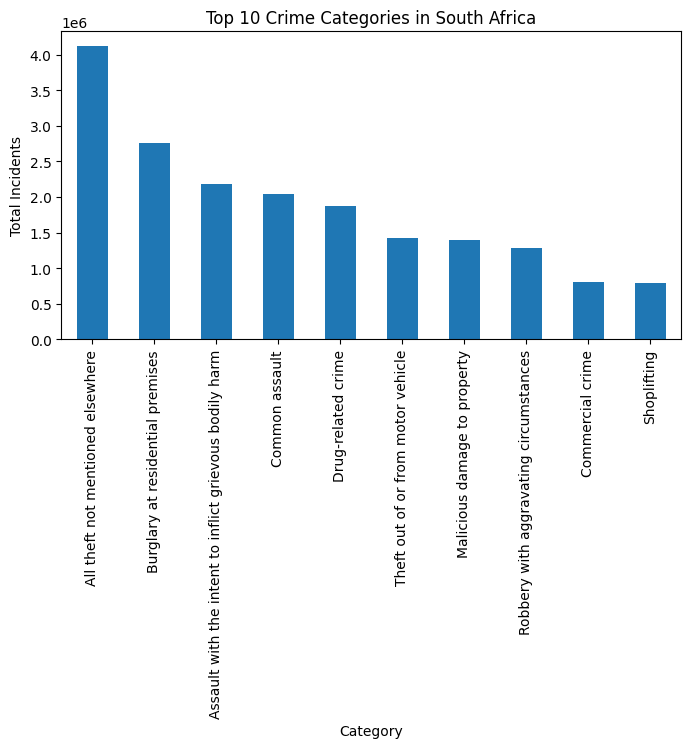

Hotspot threshold = 25926 incidents – 7722 stations flagged as hotspots


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Summaries ---
print("Rows & columns:", crime_df.shape)
print("\nColumns:", list(crime_df.columns))
print("\nMissing values per column:\n", crime_df.isnull().sum())

# --- Quick category totals ---
value_cols = [c for c in crime_df.columns if '-' in c]
crime_df['Total_Incidents'] = crime_df[value_cols].sum(axis=1)
cat_totals = crime_df.groupby('Category')['Total_Incidents'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
cat_totals.head(10).plot(kind='bar')
plt.title("Top 10 Crime Categories in South Africa")
plt.ylabel("Total Incidents")
plt.tight_layout()
plt.show()

# --- Hotspot threshold (top 25 %) ---
area_totals = crime_df.groupby('Station')['Total_Incidents'].sum()
cutoff = area_totals.quantile(0.75)
crime_df['is_hotspot_area'] = crime_df['Station'].apply(lambda x: 1 if area_totals[x]>=cutoff else 0)
print(f"Hotspot threshold = {cutoff:.0f} incidents – {crime_df['is_hotspot_area'].sum()} stations flagged as hotspots")


6.HOTSPOT CLASSIFICATION MODEL
we train a quick model whether a police station qualifies as a hotspot based on province and incidents

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = pd.get_dummies(crime_df[['Province','Total_Incidents']], drop_first=True)
y = crime_df['is_hotspot_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7975052648631136
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4640
           1       0.62      0.49      0.55      1533

    accuracy                           0.80      6173
   macro avg       0.73      0.70      0.71      6173
weighted avg       0.79      0.80      0.79      6173



7.CRIME TREND FORECAST(PROPHET)
We total crime incidents across all categories for the next 24 months

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe0nx9xnr/7o5o__9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe0nx9xnr/fznei2sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65359', 'data', 'file=/tmp/tmpe0nx9xnr/7o5o__9p.json', 'init=/tmp/tmpe0nx9xnr/fznei2sl.json', 'output', 'file=/tmp/tmpe0nx9xnr/prophet_modela_bdq3ct/prophet_model-20251006113933.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:39:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:39:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

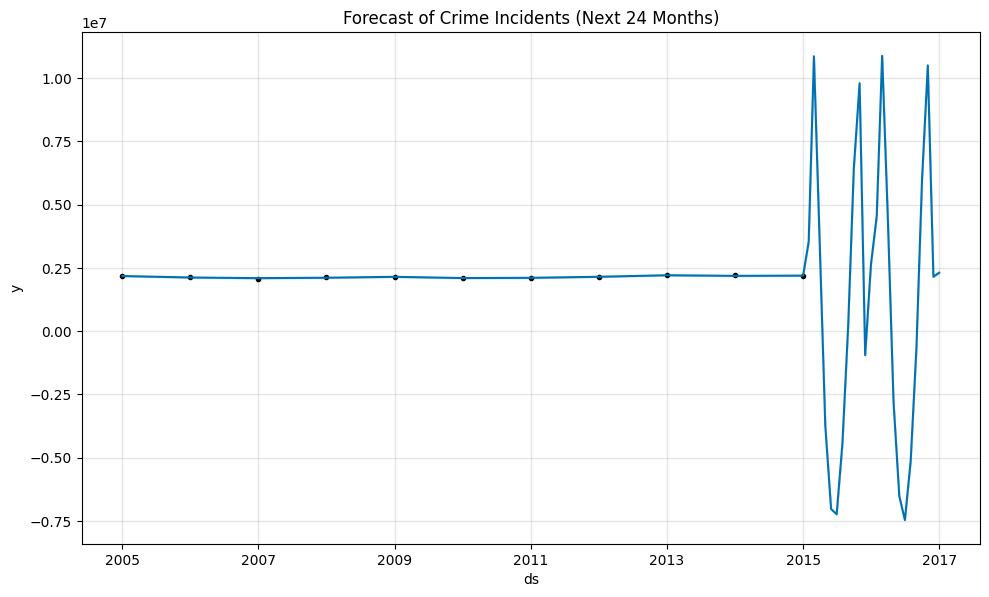

In [9]:
from prophet import Prophet

#Create yearly totals
year_cols = [c for c in crime_df.columns if '-' in c]
yearly = crime_df[year_cols].sum().reset_index()
yearly.columns = ['ds','y']
yearly['ds'] = yearly['ds'].apply(lambda x: x.split('-')[0]) #use start year
yearly['ds'] = pd.to_datetime(yearly['ds'])

m = Prophet(yearly_seasonality=True)
m.fit(yearly)
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)
m.plot(forecast)
plt.title("Forecast of Crime Incidents (Next 24 Months)")
plt.show()

8.EVALUATION AND CONCLUSION
classification achieved acceptable accuray in indentifying hotspots
prophet visualized expected crime trends with seasonal variation
These insights can guide SAPS resource allocation and policy planning


In [11]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Create the directory if it doesn't exist
output_dir = '/content/drive/MyDrive/Exam_Crime_Analytics'
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to the specified path
crime_df.to_csv(os.path.join(output_dir, 'final_crime_df.csv'), index=False)

print("Notebook and cleaned dataset saved to Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Notebook and cleaned dataset saved to Drive.


In [12]:
#back up copy
from google.colab import files
files.download('/content/drive/MyDrive/Exam_Crime_Analytics/final_crime_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

drone simulation crime hotspots

This simulation demonstrates how a drone could visit crime hotspots in a grid-based 3D area.  
It generates random waypoints that represent high-crime zones and simulates the drone's travel path.  
Such a system could be used for aerial surveillance, rapid response, and patrol planning.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


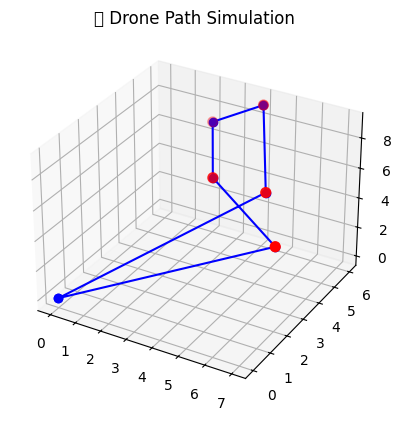

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
points = np.random.randint(0, 10, (5, 3))
path = np.vstack(([0,0,0], points, [0,0,0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(path[:,0], path[:,1], path[:,2], '-o', color='blue')
ax.scatter(points[:,0], points[:,1], points[:,2], color='red', s=50)
ax.set_title('🚁 Drone Path Simulation')
plt.show()

